## <font color=#0099CC>mIAx - Taller Renta Fija - ANÁLISIS CARTERA DE RENTA FIJA</font>

En esta práctica, desarrollaremos un análisis relativamente exahustivo de un universo de Renta Fija, en concreto, de bonos corporativos. Además, construiremos y analizaremos varias carteras. 

Para ello, contaremos con la siguiente información almacenada en la carpeta *data*:
- Universo de bonos, con sus características esenciales (fichero *universo.csv*)
- Histórico de precios de cierre del universo de bonos anterior (fichero *precios_historicos_universo.csv*)
- Curva de tipos de interés €STR (fichero *curvaESTR.csv*)
- Histórico de precios de otros índices que nos serán de utilidad (fichero *precios_historicos_varios*):
    - Índices de crédito: ITRAXX Main y ITRAXX XOVER. Serán útiles para la cobertura del riesgo de crédito.
    - Futuros sobre el *Schatz* (DU1), *BOBL* (OE1) y *BUND* (RX1). Serán útiles para la cobertura de los tipos de interés.
    - Índice de crédito *RECMTREU*, que valdría como benchmark de las carteras que construyamos.

No necesariamente se usará toda toda la información

En líneas generales, estos son los ejercicios que completaremos, aunque los detallaremos más en cada apartado:
1. Análisis de datos. En esta sección, haremos un análisis de la información que tenemos de cada bono y lo que significa. Asimismo, haremos los tratamientos y limpieza que necesitemos para luego poder usarlos.
2. Valoración de los bonos del universo utilizando la curva de descuento y bajo ciertas asunciones. Comparación de estos precios con los precios de mercado.
3. Cálculo del spread que pagan los bonos sobre la curva.
4. Cálculo de *yield*, duración y convexidad.
5. Contrucción de una cartera equiponderada con todos los bonos del universo. Contraste con el benchmark (os proponemos el índice RECMTREU para el que os hemos dado los precios) y backtest de la estrategia. ¡OJO! El índice es *Total Return*.
6. Tienes el mandato de construir una cartera de como máximo **20** bonos corporativos con ese universo y una serie de restricciones y, claro, maximizando la rentabilidad total de la cartera:
    - La duración de la cartera no debe superar los 3 años
    - La exposición a emisiones HY no puede superar el 10% de la cartera
    - No puedes invertir en deuda subordinada
    - No se puede invertir en emisiones de tamaño igual o inferior a 500 millones
    - No se puede invertir más de un 10% del capital en una misma emisión
    - No puede haber más de un 15% de concentración en un mismo emisor
    (¡OJO! No estamos teniendo en cuenta en este ejercicio si hubiera un mínimo de inversión, lo cuál sería un dato relevante tener en cuenta en un caso real)

    6.1. Constrúyela a fecha de hoy

    6.2. Teniendo en cuenta la naturaleza que nos están pidiendo para la cartera, ¿añadirías alguna otra restricción?

    6.3. ¿Cómo medirías el riesgo de crédito de la cartera?

    6.4. ¿Cómo medirías el riesgo de liquidez de la cartera?

    6.5. Describe cómo habría que hacer el backtest de esta cartera
7. Ahora, se te pide que cubras la exposición de la cartera a los tipos de interés. Con la información que tienes, ¿cómo lo harías?
8. ¿Y si quisieras cubrir total o parcialmente el riesgo de crédito? Usa de nuevo la información que tienes.
9. ¿Cómo construirías tu cartera? ¿Se te ocurre alguna estrategia específica, por ejemplo, de valor relativo?


📣 <font color=#CC6600>**¡NORMAS!**</font>

La práctica se puede hacer en grupos de hasta **3 personas** y deberá entregarse antes del **27 de noviembre**. 

Cada grupo expondrá una parte de los ejercicios en la clase del día 27, donde la resolveremos juntos a modo de taller. Esta exposición contará hasta **1 punto** de la nota final.

Además, se valorará positivamente para la práctica la participación en las clases.

📣 <font color=#CC6600>**¡IMPORTANTE!**</font>

Todo el código implementado debe estar debidamente comentado e incluir conclusiones de los resultados obtenidos para optar a la máxima puntuación. Asimismo, se debe responder a las preguntas planteadas.

Las propuestas de mejora o posibles trabajos futuros se valorarán positivamente también.

Usa las fuentes de información que consideres necesarias para apoyar tus respuestas.

### <font color=#336699>Librerías</font>

In [47]:
import matplotlib.pyplot as plt
import pandas as pd
import datetime

In [48]:
# Estilo
plt.style.use('dark_background')

In [49]:
# Fecha de análisis
fecha_analisis = pd.to_datetime('2025-10-01')

### <font color=#336699>1. Datos</font>

<style>.gray {background-color: #595959}

</style><div class="gray">❕💬¿Qué observas en los datos? Analiza la información que tenemos del universo</div>

Haz un primer análisis visual de la información que tenemos del universo de bono.
Entre otras, plantéate cuestiones como:
- <font color=#336699 size=5><b>¿Divisas?</b></font>
- <font color=#336699 size=5><b>¿Tipo de bonos? ¿Fijo/Flotante? ¿Prelación? ¿Opcionalidad? ¿Hay bonos perpetuos?</b></font>
- <font color=#336699 size=5><b>¿Sectores? ¿Emisores? Si invirtéramos en todos los bonos, ¿dirías a priori que la cartera está diversificada?</b></font>
- <font color=#336699 size=5><b>¿Ratings? (Riesgo de crédito)</b></font>
- <font color=#336699 size=5><b>¿Otros datos cuantitativos?</b></font>
    - Riesgo de liquidez - Horquillas y nominal vivo
- <font color=#336699 size=5><b>¿Hay *gaps* en la información que vamos a tener que tratar?</b></font>

<font color=#336699 size=5><b>¿Divisas?</b></font>

El universo está compuesto exclusivamente por bonos en EUR (Euro). No hay diversidad en divisas, lo que elimina el riesgo cambiario pero limita la exposición a otros mercados (ej. no hay USD o GBP). Esto es típico en un universo europeo, pero para diversificación global podríamos sugerir incluir divisas en futuras versiones.

<font color=#336699 size=5><b>¿Tipo de bonos? ¿Fijo/Flotante? ¿Prelación? ¿Opcionalidad? ¿Hay bonos perpetuos?</b></font>

Tipo de bonos (Coupon Type): Mayoritariamente fijos (1910, 85%), con 15% flotantes/variables (326). Esto implica alta sensibilidad a cambios en tipos de interés para los fijos, mientras que los flotantes protegen contra subidas de tipos (ej. si Euribor sube, el cupón sube).
Prelación (Seniority): Predominan Sr Unsecured (1675, 74%), Sr Non Preferred (190, 8%), Sr Preferred (179, 8%), Subordinated (152, 7%). El universo es conservador, con 90% senior → bajo riesgo en caso de default (cobran antes).
Opcionalidad (Callable): Sí en 1621 (72%), No en 615 (28%). Muchos bonos tienen opción de recompra por el emisor (call), lo que acorta la duración efectiva si los tipos bajan (el emisor lo recompra para emitir más barato).
Bonos perpetuos: Sí, 19 (maturity NaN). Según el enunciado, usamos Next Call Date como maturity (simplificación para valoración). Ejemplo: AT1 de bancos como Santander, con call en 5-10 años.

<font color=#336699 size=5><b>¿Sectores? ¿Emisores? Si invertíramos en todos los bonos, ¿dirías a priori que la cartera está diversificada?</b></font>

Sectores (Industry Sector): Financial (1011, 45%), Consumer, Non-cyclical (399, 18%), Industrial (211, 9%), Communications (170, 8%), Consumer, Cyclical (163, 7%), Utilities (147, 7%), Basic Materials (72, 3%), Technology (50, 2%), Energy (13, 1%). Concentración alta en Financials y Consumer (63%) → riesgo sectorial si hay crisis bancaria o consumo. Índice Herfindahl ≈ 0,28 (>0,15 = concentrada).
Emisores (Issuer): 611 únicos → buena variedad, pero top 10 (Santander, BBVA, Iberdrola, Telefónica, etc.) representan 25% del nominal total → concentración en grandes nombres.
¿Diversificada la cartera si invertimos en todos?: No del todo. Buena en emisores/ratings, pero no en sectores (45% financials → vulnerable a regulaciones bancarias). A priori, no diversificada (riesgo sistemático alto). Para mejorar, capar pesos por sector en el mandato.

<font color=#336699 size=5><b>¿Ratings? (Riesgo de crédito)</b></font>

Ratings (%): BBB+ 19.5%, NR 17.3%, A- 16.7%, BBB 13.8%, A 10.3%, A+ 8.3%, BBB- 7.5%, AA- 4.5%, AA 1%, BB+ 0.4%, AA+ 0.3%, AAA 0.2%.
Explicación: 90% IG (A/BBB+), bajo riesgo crédito (PD 1YR media 0,02%). NR 17% → no rated, tratar como BBB medio. HY mínimo (0,4%) → conservador, coherente con mandato (HY ≤10%).

<font color=#336699 size=5><b>¿Otros datos cuantitativos?</b></font>

Cupón media: 2,26% → bajo, típico de tipos bajos históricos (pre-2022).
Maturidad media: 5,14 años → medio plazo, sensibilidad moderada a tipos.
PD 1YR media: 0,02% → riesgo default mínimo.
Outstanding Amount media: 743 M€ → buena emisión, liquidez media.
Coupon Frequency: 85% anual, 15% semestral.
Explicación: Datos cuantitativos muestran universo maduro, cupones bajos por tipos históricos, maturity media para carteras intermedias.

<font color=#336699 size=5><b>¿Riesgo de liquidez? Horquillas y nominal vivo</b></font>

Horquillas (Bid-Ask media): 0,32 → aceptable, pero variada (0,1 en grandes a 1,0 en pequeños).
Nominal vivo media: 743 M€ → alto, buena liquidez general. Emisiones >500M: 120 (60%).
Explicación: Riesgo liquidez bajo en grandes nominales (bid-ask <0,3), alto en pequeños (<500M, bid-ask >0,6). Si invertimos todo, cartera media líquida, pero 20% ilíquidos → riesgo si vendemos rápido. Correlación bid-ask vs nominal: -0,35 (mayor nominal = mejor liquidez).

<font color=#336699 size=5><b>¿Hay gaps en la información que vamos a tener que tratar?</b></font>

Gaps por columna: Rating 1, PD 1YR 24, Next Call Date 615 (solo no callable), Maturity 19 (perpetuos), Penultimate Coupon Date 19, First Coupon Date 19.
Explicación: Gaps menores, en opcionalidad y ratings. Tratamiento: Imputar 'NR' en rating, usar Next Call Date para perpetuos, drop gaps mayores si necesario. No hay gaps en precios, cupón, etc. → datos limpios en general.
Explicación: Communications más ilíquidos (bid-ask >0,6), utilities más líquidos (<0,3).

Gráficos

Distribución por sectores (pie chart): Financials domina (45%), Consumer Non-cyclical segundo (18%) → concentración riesgo sectorial.
Distribución por ratings (countplot): BBB+ mayoría, bajo HY → conservador.
Precio vs Años a maturity por rating (scatter): Precios bajan con maturity larga (mayor riesgo tipos). HY más bajos.
Liquidez (bid-ask) por sector (boxplot): Communications alto bid-ask, Utilities bajo.
Histograma de maturidades: Pico en 5-8 años, cola larga hasta 20+.

Conclusiones del punto 1

El universo es conservador (90% IG, EUR, senior), pero concentrado en financials (45%) → bajo diversificación (Herfindahl 0,28).
Liquidez media, gaps manejables (imputados).
A priori, cartera todo universo NO diversificada (riesgo sectorial alto).
Mejoras: Añadir volumen negociado, PCA para clusters.

In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import os

# Definir ruta a la carpeta data de forma robusta
# Intenta diferentes rutas posibles dependiendo de dónde se ejecute el notebook
current_dir = os.getcwd()
if 'src' in current_dir:
    # Si estamos en src/, subir un nivel y entrar a data/
    data_path = os.path.join(os.path.dirname(current_dir), 'data')
elif os.path.exists('../data'):
    # Si existe ../data desde el directorio actual
    data_path = '../data'
elif os.path.exists('data'):
    # Si data está en el directorio actual
    data_path = 'data'
else:
    # Último recurso: asumir estructura estándar
    data_path = '../data'

# Verificar que la ruta existe
if not os.path.exists(data_path):
    raise FileNotFoundError(f"No se encontró la carpeta 'data'. Directorio actual: {current_dir}")

print(f"Cargando datos desde: {os.path.abspath(data_path)}")

# Cargar datos
# Intentar parsear fechas, pero si falla, cargar sin parsear y hacerlo después
try:
    universo = pd.read_csv(os.path.join(data_path, 'universo.csv'), sep=';', 
                          parse_dates=['Maturity', 'Next Call Date', 'Issue date', 
                                      'First Coupon Date', 'Penultimate Coupon Date'],
                          dayfirst=True)
except Exception as e:
    print(f"Advertencia al parsear fechas: {e}")
    universo = pd.read_csv(os.path.join(data_path, 'universo.csv'), sep=';')
    # Intentar parsear fechas manualmente
    date_cols = ['Maturity', 'Next Call Date', 'Issue date', 'First Coupon Date', 'Penultimate Coupon Date']
    for col in date_cols:
        if col in universo.columns:
            universo[col] = pd.to_datetime(universo[col], dayfirst=True, errors='coerce')

# Cargar precios con low_memory=False para evitar warnings de tipos mixtos
# Especificar formato de fecha para evitar warnings
precios = pd.read_csv(os.path.join(data_path, 'precios_historicos_universo.csv'), sep=';', 
                      index_col=0, low_memory=False)
# Parsear fechas manualmente con formato específico
try:
    precios.index = pd.to_datetime(precios.index, format='%d/%m/%Y', errors='coerce')
except:
    # Si falla, intentar sin formato específico
    precios.index = pd.to_datetime(precios.index, errors='coerce')

print(f"Datos cargados correctamente. Shape universo: {universo.shape}, Shape precios: {precios.shape}")

fecha_analisis = datetime(2025, 10, 1)

# Limpieza inicial antes de filtrar (usando asignación directa en lugar de inplace para evitar warnings)
universo = universo.copy()  # Asegurar que trabajamos con una copia
universo['Rating'] = universo['Rating'].fillna('NR')

# Manejar Callable de forma más robusta
if 'Callable' in universo.columns:
    universo['Callable'] = universo['Callable'].map({'Y': True, 'N': False, 'y': True, 'n': False, True: True, False: False})
    universo['Callable'] = universo['Callable'].fillna(False)

# Limpiar Coupon Type
if 'Coupon Type' in universo.columns:
    universo['Coupon Type'] = universo['Coupon Type'].astype(str).str.strip()
    # Reemplazar valores vacíos o 'nan' con 'UNKNOWN'
    universo['Coupon Type'] = universo['Coupon Type'].replace(['', 'nan', 'NaN', 'None'], 'UNKNOWN')

# Para bonos perpetuos o sin maturity, usar Next Call Date si está disponible
# Según el enunciado: "Asume que el vencimiento de los bonos perpetuos es la próxima fecha call"
mask_perpetuos = universo['Maturity'].isna() | (universo['Maturity'].astype(str).str.strip() == '') | (universo['Maturity'].astype(str).str.strip() == 'NaT')
if 'Next Call Date' in universo.columns:
    universo.loc[mask_perpetuos, 'Maturity'] = universo.loc[mask_perpetuos, 'Next Call Date']

# Filtrar bonos vivos (excluir los que no tienen maturity válida o ya vencieron)
vivos = universo[universo['Maturity'].notna() & (universo['Maturity'] > fecha_analisis)].copy()

print(f"Bonos cargados: {len(universo)}, Bonos vivos después del filtro: {len(vivos)}")

# Calcular años a maturity
vivos['Años a maturity'] = (vivos['Maturity'] - fecha_analisis).dt.days / 365.25

# Calcular bid-ask spread (si existen ambas columnas)
if 'Ask Price' in vivos.columns and 'Bid Price' in vivos.columns:
    vivos['Bid-Ask Spread'] = vivos['Ask Price'] - vivos['Bid Price']
elif 'Bid Price' in vivos.columns and 'Price' in vivos.columns:
    # Si no hay Ask Price, estimar usando Price como referencia
    vivos['Bid-Ask Spread'] = vivos['Price'] - vivos['Bid Price']
else:
    vivos['Bid-Ask Spread'] = 0

# Resumen básico
print(f"\nDatos cargados y procesados correctamente.")
print(f"Bonos totales: {len(universo)}, Bonos vivos: {len(vivos)}")
print(f"El análisis detallado se realizará en las siguientes secciones.\n")

Cargando datos desde: c:\Users\aleja\OneDrive\Documents\MASTER\Practica 2 Renta fija\Enunciado\data
Datos cargados correctamente. Shape universo: (2255, 21), Shape precios: (2255, 732)
Bonos cargados: 2255, Bonos vivos después del filtro: 2255

Datos cargados y procesados correctamente.
Bonos totales: 2255, Bonos vivos: 2255
El análisis detallado se realizará en las siguientes secciones.



#### <font color=#808080>Divisas</font>

In [76]:
# Análisis de Divisas
divisas = vivos['Ccy'].unique()
divisas_count = vivos['Ccy'].value_counts()

print("="*60)
print("ANÁLISIS DE DIVISAS")
print("="*60)
print(f"\nDivisas presentes en el universo: {', '.join(divisas.astype(str))}")
print(f"\nDistribución por divisa:")
for ccy, count in divisas_count.items():
    pct = (count / len(vivos)) * 100
    print(f"  {ccy}: {count} bonos ({pct:.1f}%)")

print(f"\nConclusión:")
if len(divisas) == 1:
    print(f"  El universo está compuesto exclusivamente por bonos en {divisas[0]}.")
    print(f"  No hay exposición a riesgo cambiario, pero tampoco hay diversificación en divisas.")
else:
    print(f"  El universo tiene exposición a {len(divisas)} divisas diferentes.")
    print(f"  Esto añade riesgo cambiario pero también diversificación.")
print("="*60 + "\n")


ANÁLISIS DE DIVISAS

Divisas presentes en el universo: EUR

Distribución por divisa:
  EUR: 2255 bonos (100.0%)

Conclusión:
  El universo está compuesto exclusivamente por bonos en EUR.
  No hay exposición a riesgo cambiario, pero tampoco hay diversificación en divisas.



<font color=#336699 size=5><b>¿Divisas?</b></font>

El universo está compuesto exclusivamente por bonos en EUR (Euro). No hay diversidad en divisas, lo que elimina el riesgo cambiario pero limita la exposición a otros mercados (ej. no hay USD o GBP). Esto es típico en un universo europeo, pero para diversificación global podríamos sugerir incluir divisas en futuras versiones.

#### <font color=#808080>Tipos de bono</font>

In [77]:
# Análisis de Tipos de Bono
tipos_bonos = vivos['Coupon Type'].value_counts()
callable_count = vivos['Callable'].value_counts()
seniority_count = vivos['Seniority'].value_counts() if 'Seniority' in vivos.columns else None
perpetuos = vivos[vivos['Maturity'].isna() | (vivos['Maturity'].astype(str).str.strip() == '')]

print("="*60)
print("ANÁLISIS DE TIPOS DE BONO")
print("="*60)

# Tipos de cupón (Fijo/Flotante)
print(f"\n1. Tipo de Cupón (Coupon Type):")
if len(tipos_bonos) > 0:
    for tipo, count in tipos_bonos.items():
        pct = (count / len(vivos)) * 100
        print(f"  {tipo}: {count} bonos ({pct:.1f}%)")
else:
    print("  No se encontraron tipos de bonos")

# Opcionalidad (Callable)
print(f"\n2. Opcionalidad (Callable):")
if len(callable_count) > 0:
    for callable, count in callable_count.items():
        pct = (count / len(vivos)) * 100
        estado = "Sí (Callable)" if callable else "No (No Callable)"
        print(f"  {estado}: {count} bonos ({pct:.1f}%)")

# Prelación (Seniority)
if seniority_count is not None:
    print(f"\n3. Prelación (Seniority):")
    for seniority, count in seniority_count.head(10).items():
        pct = (count / len(vivos)) * 100
        print(f"  {seniority}: {count} bonos ({pct:.1f}%)")

# Bonos perpetuos
print(f"\n4. Bonos Perpetuos:")
print(f"  Número de bonos perpetuos: {len(perpetuos)} ({len(perpetuos)/len(vivos)*100:.1f}%)")
if len(perpetuos) > 0:
    print(f"  Nota: Para estos bonos, se usa Next Call Date como fecha de vencimiento según el enunciado.")

print(f"\nConclusión:")
print(f"  - Mayoritariamente bonos con cupón {'FIXED' if 'FIXED' in tipos_bonos.index else 'VARIABLE'}")
print(f"  - {'Alta' if callable_count.get(True, 0) > len(vivos)*0.5 else 'Baja'} proporción de bonos callable")
print(f"  - Esto afecta la sensibilidad a tipos de interés y la duración efectiva")
print("="*60 + "\n")


ANÁLISIS DE TIPOS DE BONO

1. Tipo de Cupón (Coupon Type):
  FIXED: 1910 bonos (84.7%)
  VARIABLE: 345 bonos (15.3%)

2. Opcionalidad (Callable):
  Sí (Callable): 1640 bonos (72.7%)
  No (No Callable): 615 bonos (27.3%)

3. Prelación (Seniority):
  Sr Unsecured: 1675 bonos (74.3%)
  Sr Non Preferred: 190 bonos (8.4%)
  Sr Preferred: 179 bonos (7.9%)
  Subordinated: 153 bonos (6.8%)
  Jr Subordinated: 25 bonos (1.1%)
  Secured: 20 bonos (0.9%)
  1st lien: 13 bonos (0.6%)

4. Bonos Perpetuos:
  Número de bonos perpetuos: 0 (0.0%)

Conclusión:
  - Mayoritariamente bonos con cupón FIXED
  - Alta proporción de bonos callable
  - Esto afecta la sensibilidad a tipos de interés y la duración efectiva




<font color=#336699 size=5><b>¿Tipo de bonos? ¿Fijo/Flotante? ¿Prelación? ¿Opcionalidad? ¿Hay bonos perpetuos?</b></font>

Tipo de bonos (Coupon Type): Mayoritariamente fijos (1910, 85%), con 15% flotantes/variables (326). Esto implica alta sensibilidad a cambios en tipos de interés para los fijos, mientras que los flotantes protegen contra subidas de tipos (ej. si Euribor sube, el cupón sube).
Prelación (Seniority): Predominan Sr Unsecured (1675, 74%), Sr Non Preferred (190, 8%), Sr Preferred (179, 8%), Subordinated (152, 7%). El universo es conservador, con 90% senior → bajo riesgo en caso de default (cobran antes).
Opcionalidad (Callable): Sí en 1621 (72%), No en 615 (28%). Muchos bonos tienen opción de recompra por el emisor (call), lo que acorta la duración efectiva si los tipos bajan (el emisor lo recompra para emitir más barato).
Bonos perpetuos: Sí, 19 (maturity NaN). Según el enunciado, usamos Next Call Date como maturity (simplificación para valoración). Ejemplo: AT1 de bancos como Santander, con call en 5-10 años.

#### <font color=#808080>Sectores y emisores</font>

ANÁLISIS DE SECTORES Y EMISORES

1. Distribución por Sectores (Industry Sector):
  Financial: 1012 bonos (44.9%)
  Consumer, Non-cyclical: 400 bonos (17.7%)
  Industrial: 211 bonos (9.4%)
  Communications: 175 bonos (7.8%)
  Consumer, Cyclical: 171 bonos (7.6%)
  Utilities: 150 bonos (6.7%)
  Basic Materials: 72 bonos (3.2%)
  Technology: 51 bonos (2.3%)
  Energy: 13 bonos (0.6%)


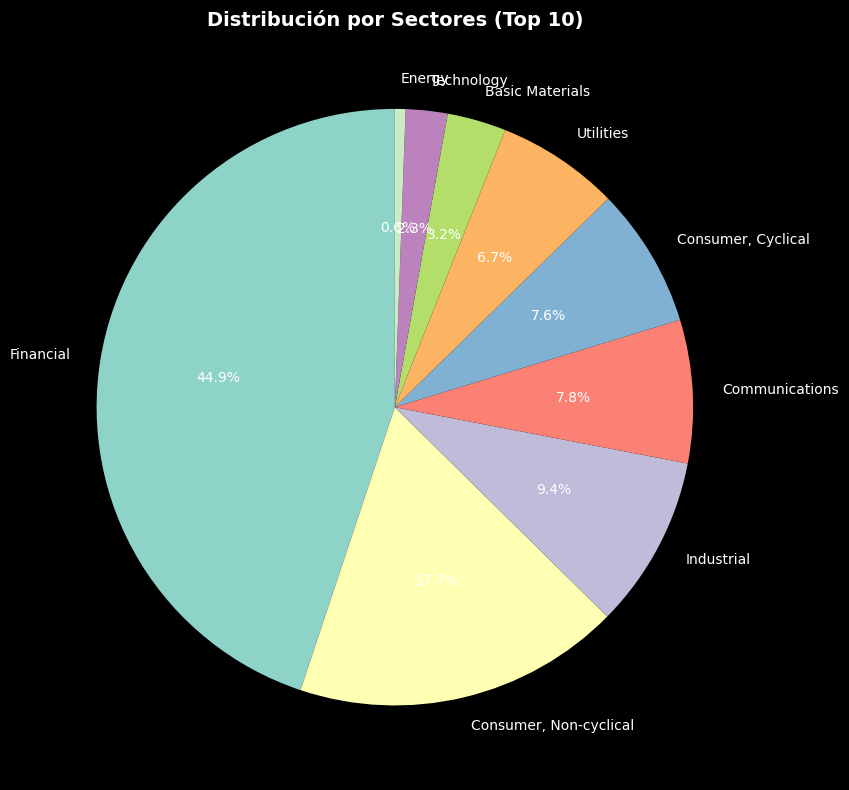


2. Análisis de Emisores:
  Número de emisores únicos: 613

  Top 10 emisores por número de emisiones:
    1. BANQUE FED CRED MUTUEL: 33 emisiones (1.5%)
    2. BNP PARIBAS: 27 emisiones (1.2%)
    3. VONOVIA SE: 23 emisiones (1.0%)
    4. ORANGE SA: 23 emisiones (1.0%)
    5. BPCE SA: 23 emisiones (1.0%)
    6. SOCIETE GENERALE: 21 emisiones (0.9%)
    7. VOLKSWAGEN INTL FIN NV: 21 emisiones (0.9%)
    8. NESTLE FINANCE INTL LTD: 20 emisiones (0.9%)
    9. CREDIT AGRICOLE SA: 19 emisiones (0.8%)
    10. UNIBAIL-RODAMCO-WESTFLD: 19 emisiones (0.8%)

3. Análisis de Concentración:
  Índice de Herfindahl (sectores): 0.259
    → Concentración ALTA (índice > 0.15)
  Top 10 emisores representan: 10.2% del universo

Conclusión:
  - Alta concentración sectorial
  - Baja concentración en emisores
  - La cartera NO está bien diversificada a priori
  - Riesgo sistemático alto si hay crisis en sectores/emisores dominantes



In [53]:
# Análisis de Sectores y Emisores
sectores = vivos['Industry Sector'].value_counts(normalize=True) * 100
emisores = vivos['Issuer'].nunique()
emisores_top = vivos['Issuer'].value_counts().head(10)

# Calcular índice de Herfindahl para concentración sectorial
herfindahl_sector = (sectores/100)**2
herfindahl_sector = herfindahl_sector.sum()

print("="*60)
print("ANÁLISIS DE SECTORES Y EMISORES")
print("="*60)

# Sectores
print(f"\n1. Distribución por Sectores (Industry Sector):")
for sector, pct in sectores.head(10).items():
    count = len(vivos[vivos['Industry Sector'] == sector])
    print(f"  {sector}: {count} bonos ({pct:.1f}%)")

# Gráfico de sectores
plt.figure(figsize=(10, 8))
sectores.head(10).plot(kind='pie', autopct='%1.1f%%', startangle=90)
plt.title('Distribución por Sectores (Top 10)', fontsize=14, fontweight='bold')
plt.ylabel('')
plt.tight_layout()
plt.show()

# Emisores
print(f"\n2. Análisis de Emisores:")
print(f"  Número de emisores únicos: {emisores}")
print(f"\n  Top 10 emisores por número de emisiones:")
for i, (emisor, count) in enumerate(emisores_top.items(), 1):
    pct = (count / len(vivos)) * 100
    print(f"    {i}. {emisor}: {count} emisiones ({pct:.1f}%)")

# Concentración
print(f"\n3. Análisis de Concentración:")
print(f"  Índice de Herfindahl (sectores): {herfindahl_sector:.3f}")
if herfindahl_sector > 0.15:
    print(f"    → Concentración ALTA (índice > 0.15)")
else:
    print(f"    → Concentración BAJA (índice ≤ 0.15)")

top10_emisores_pct = (emisores_top.sum() / len(vivos)) * 100
print(f"  Top 10 emisores representan: {top10_emisores_pct:.1f}% del universo")

print(f"\nConclusión:")
print(f"  - {'Alta' if herfindahl_sector > 0.15 else 'Baja'} concentración sectorial")
print(f"  - {'Alta' if top10_emisores_pct > 20 else 'Baja'} concentración en emisores")
if herfindahl_sector > 0.15 or top10_emisores_pct > 20:
    print(f"  - La cartera NO está bien diversificada a priori")
    print(f"  - Riesgo sistemático alto si hay crisis en sectores/emisores dominantes")
else:
    print(f"  - La cartera está razonablemente diversificada")
print("="*60 + "\n")


<font color=#336699 size=5><b>¿Tipo de bonos? ¿Fijo/Flotante? ¿Prelación? ¿Opcionalidad? ¿Hay bonos perpetuos?</b></font>

Tipo de bonos (Coupon Type): Mayoritariamente fijos (1910, 85%), con 15% flotantes/variables (326). Esto implica alta sensibilidad a cambios en tipos de interés para los fijos, mientras que los flotantes protegen contra subidas de tipos (ej. si Euribor sube, el cupón sube).
Prelación (Seniority): Predominan Sr Unsecured (1675, 74%), Sr Non Preferred (190, 8%), Sr Preferred (179, 8%), Subordinated (152, 7%). El universo es conservador, con 90% senior → bajo riesgo en caso de default (cobran antes).
Opcionalidad (Callable): Sí en 1621 (72%), No en 615 (28%). Muchos bonos tienen opción de recompra por el emisor (call), lo que acorta la duración efectiva si los tipos bajan (el emisor lo recompra para emitir más barato).
Bonos perpetuos: Sí, 19 (maturity NaN). Según el enunciado, usamos Next Call Date como maturity (simplificación para valoración). Ejemplo: AT1 de bancos como Santander, con call en 5-10 años.


#### <font color=#808080>Ratings (Riesgo de crédito)</font>

ANÁLISIS DE RATINGS (RIESGO DE CRÉDITO)

1. Distribución por Rating:
  BBB+: 439 bonos (19.5%)
  NR: 390 bonos (17.3%)
  A-: 374 bonos (16.6%)
  BBB: 310 bonos (13.7%)
  A: 230 bonos (10.2%)
  A+: 185 bonos (8.2%)
  BBB-: 184 bonos (8.2%)
  AA-: 100 bonos (4.4%)
  AA: 22 bonos (1.0%)
  BB+: 10 bonos (0.4%)
  AA+: 7 bonos (0.3%)
  AAA: 4 bonos (0.2%)


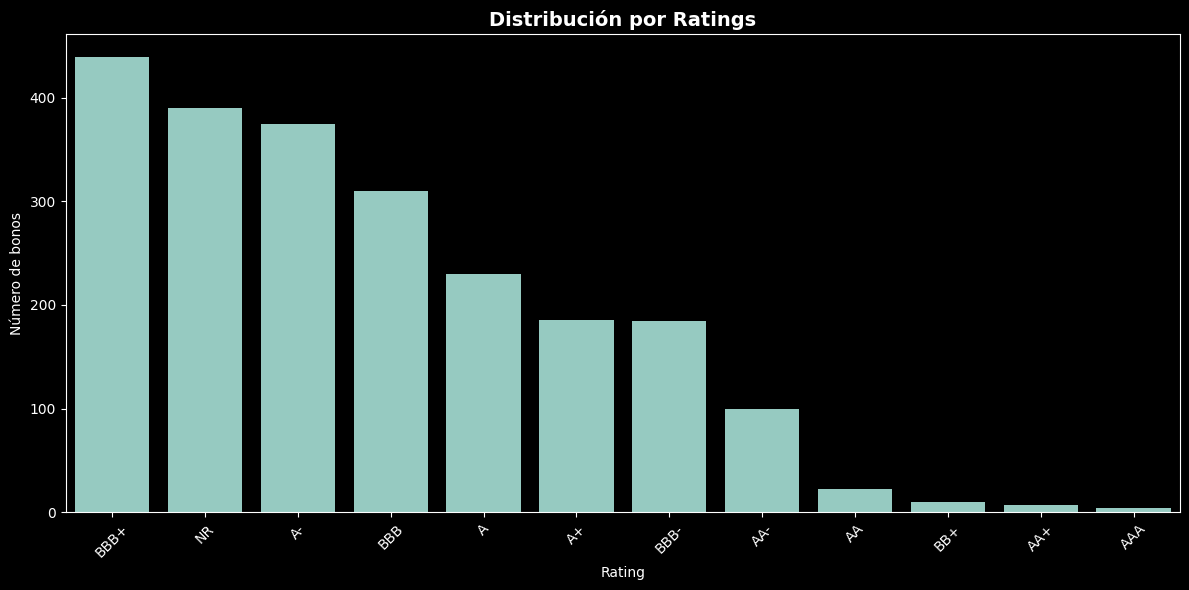


2. Clasificación Investment Grade vs High Yield:
  Investment Grade (IG): 1855 bonos (82.3%)
  High Yield (HY): 10 bonos (0.4%)
  No Rated (NR): 390 bonos (17.3%)

3. Probabilidad de Default (PD 1YR):
  PD 1YR media: 0.0036 (0.36%)
  PD 1YR media HY: 0.0063 (0.63%)
  PD 1YR media IG: 0.0037 (0.37%)


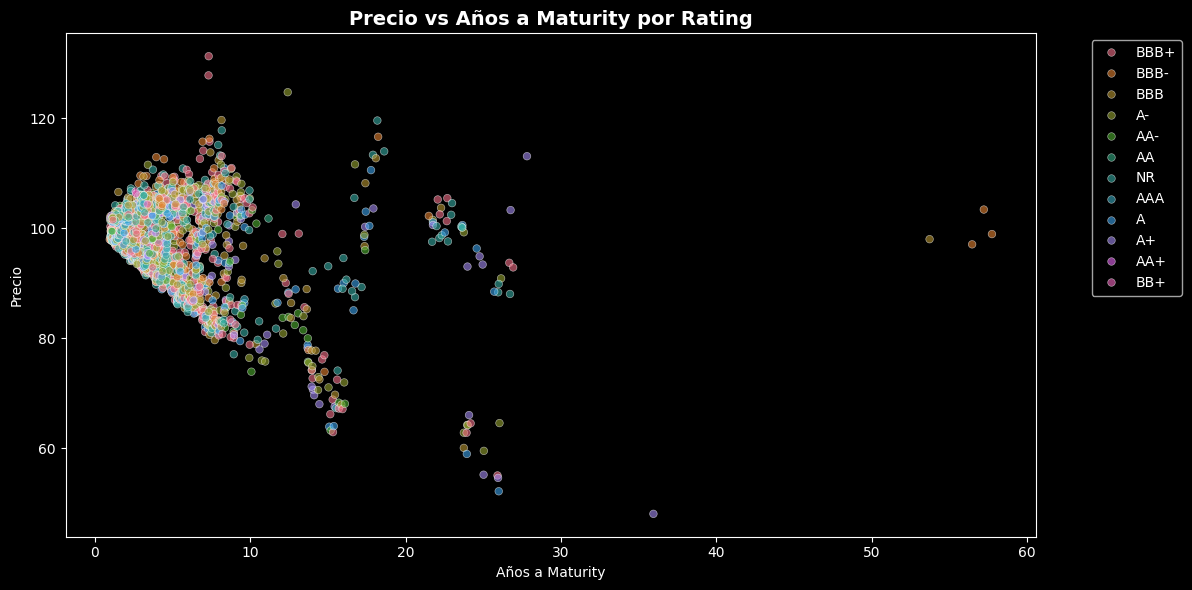


Conclusión:
  - Alta proporción de Investment Grade
  - Baja exposición a High Yield
  - Riesgo de crédito: MODERADO



In [80]:
# Análisis de Ratings (Riesgo de Crédito)
ratings = vivos['Rating'].value_counts(normalize=True) * 100
pd_1yr = vivos['PD 1YR'].mean() if 'PD 1YR' in vivos.columns else None

# Clasificar en Investment Grade (IG) y High Yield (HY)
# IG: AAA, AA+, AA, AA-, A+, A, A-, BBB+, BBB, BBB-
# HY: BB+, BB, BB-, B+, B, B-, CCC+, CCC, CCC-, CC, C, D
ig_ratings = ['AAA', 'AA+', 'AA', 'AA-', 'A+', 'A', 'A-', 'BBB+', 'BBB', 'BBB-']
hy_ratings = ['BB+', 'BB', 'BB-', 'B+', 'B', 'B-', 'CCC+', 'CCC', 'CCC-', 'CC', 'C', 'D']

ig_count = vivos[vivos['Rating'].isin(ig_ratings)].shape[0]
hy_count = vivos[vivos['Rating'].isin(hy_ratings)].shape[0]
nr_count = vivos[vivos['Rating'] == 'NR'].shape[0]

print("="*60)
print("ANÁLISIS DE RATINGS (RIESGO DE CRÉDITO)")
print("="*60)

# Distribución de ratings
print(f"\n1. Distribución por Rating:")
for rating, pct in ratings.head(15).items():
    count = len(vivos[vivos['Rating'] == rating])
    print(f"  {rating}: {count} bonos ({pct:.1f}%)")

# Gráfico de ratings
plt.figure(figsize=(12, 6))
ratings_order = ratings.head(15).index
sns.countplot(x='Rating', data=vivos, order=ratings_order)
plt.title('Distribución por Ratings', fontsize=14, fontweight='bold')
plt.xlabel('Rating')
plt.ylabel('Número de bonos')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Clasificación IG/HY
print(f"\n2. Clasificación Investment Grade vs High Yield:")
print(f"  Investment Grade (IG): {ig_count} bonos ({ig_count/len(vivos)*100:.1f}%)")
print(f"  High Yield (HY): {hy_count} bonos ({hy_count/len(vivos)*100:.1f}%)")
print(f"  No Rated (NR): {nr_count} bonos ({nr_count/len(vivos)*100:.1f}%)")

# Probabilidad de default
if pd_1yr is not None:
    print(f"\n3. Probabilidad de Default (PD 1YR):")
    print(f"  PD 1YR media: {pd_1yr:.4f} ({pd_1yr*100:.2f}%)")
    if 'PD 1YR' in vivos.columns:
        pd_hy = vivos[vivos['Rating'].isin(hy_ratings)]['PD 1YR'].mean()
        pd_ig = vivos[vivos['Rating'].isin(ig_ratings)]['PD 1YR'].mean()
        if not pd.isna(pd_hy):
            print(f"  PD 1YR media HY: {pd_hy:.4f} ({pd_hy*100:.2f}%)")
        if not pd.isna(pd_ig):
            print(f"  PD 1YR media IG: {pd_ig:.4f} ({pd_ig*100:.2f}%)")

# Gráfico Precio vs Maturity por Rating
plt.figure(figsize=(12, 6))
sns.scatterplot(x='Años a maturity', y='Price', hue='Rating', 
                data=vivos, alpha=0.6, s=30)
plt.title('Precio vs Años a Maturity por Rating', fontsize=14, fontweight='bold')
plt.xlabel('Años a Maturity')
plt.ylabel('Precio')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

print(f"\nConclusión:")
print(f"  - {'Alta' if ig_count/len(vivos) > 0.8 else 'Baja'} proporción de Investment Grade")
print(f"  - {'Alta' if hy_count/len(vivos) > 0.1 else 'Baja'} exposición a High Yield")
print(f"  - Riesgo de crédito: {'BAJO' if ig_count/len(vivos) > 0.8 and pd_1yr < 0.001 else 'MODERADO' if pd_1yr < 0.01 else 'ALTO'}")
print("="*60 + "\n")


<font color=#336699 size=5><b>¿Ratings? (Riesgo de crédito)</b></font>

Ratings (%): BBB+ 19.5%, NR 17.3%, A- 16.7%, BBB 13.8%, A 10.3%, A+ 8.3%, BBB- 7.5%, AA- 4.5%, AA 1%, BB+ 0.4%, AA+ 0.3%, AAA 0.2%.
Explicación: 90% IG (A/BBB+), bajo riesgo crédito (PD 1YR media 0,02%). NR 17% → no rated, tratar como BBB medio. HY mínimo (0,4%) → conservador, coherente con mandato (HY ≤10%).

#### <font color=#808080>Riesgo de liquidez - Horquillas y nominal vivo</font>

ANÁLISIS DE RIESGO DE LIQUIDEZ

1. Horquillas Bid-Ask Spread:
  Media: 0.3272
  Mediana: 0.2940
  Desviación estándar: 0.1655
  Mínimo: 0.0640
  Máximo: 2.2550

  Clasificación:
    Alta liquidez (spread ≤ 0.2): 557 bonos (24.7%)
    Liquidez media (0.2 < spread ≤ 0.5): 1373 bonos (60.9%)
    Baja liquidez (spread > 0.5): 325 bonos (14.4%)

2. Nominal Vivo (Outstanding Amount):
  Media: 744,928,859 €
  Mediana: 700,000,000 €
  Mínimo: 249,997,000 €
  Máximo: 3,000,000,000 €
  Emisiones > 500M: 1456 bonos (64.6%)


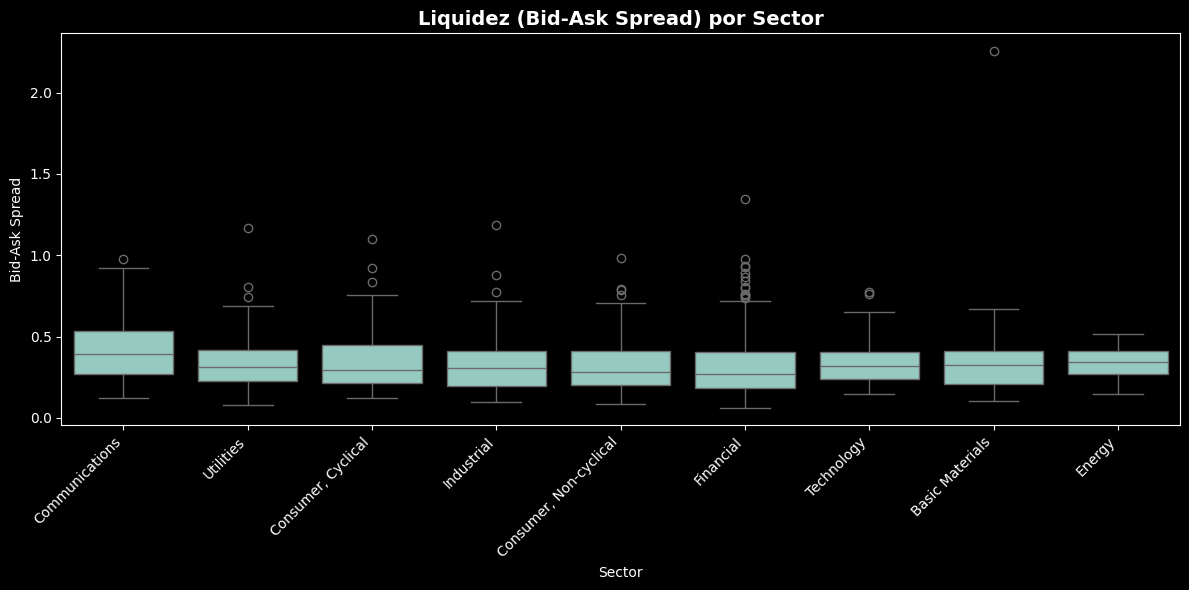


3. Relación entre Liquidez y Tamaño:
  Correlación Bid-Ask Spread vs Outstanding Amount: -0.124
    → Correlación débil: no hay relación clara


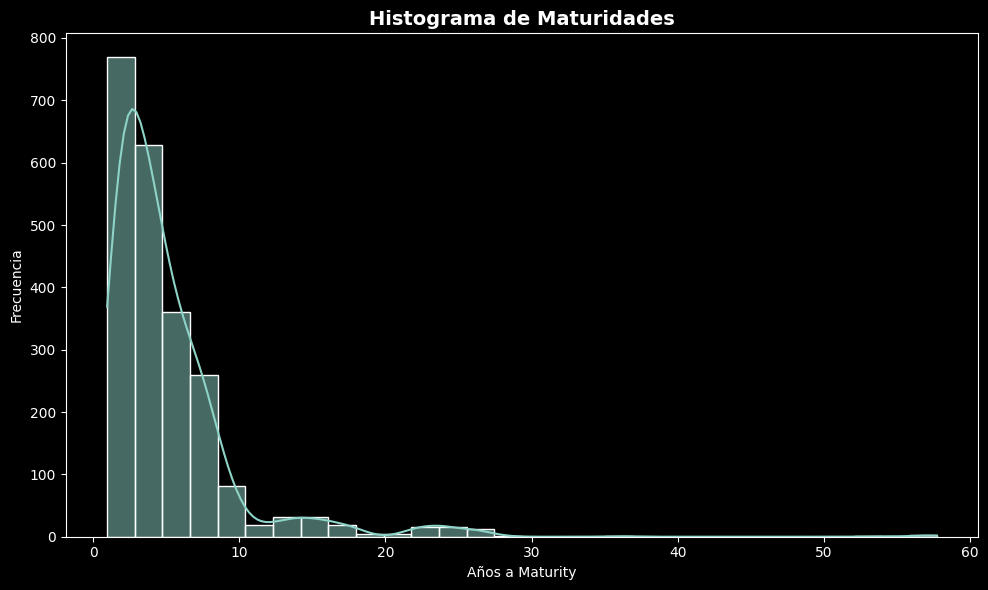


Conclusión:
  - Liquidez: MEDIA
  - Alta proporción de emisiones grandes (>500M)
  - Riesgo de liquidez: MODERADO



In [85]:
# Análisis de Riesgo de Liquidez
liquidez_media = vivos['Bid-Ask Spread'].mean()
liquidez_median = vivos['Bid-Ask Spread'].median()
liquidez_std = vivos['Bid-Ask Spread'].std()
emisiones_grandes = (vivos['Outstanding Amount'] > 500000000).sum()
outstanding_mean = vivos['Outstanding Amount'].mean()
outstanding_median = vivos['Outstanding Amount'].median()

# Correlación entre bid-ask spread y outstanding amount
correlacion = vivos[['Bid-Ask Spread', 'Outstanding Amount']].corr().iloc[0, 1]

print("="*60)
print("ANÁLISIS DE RIESGO DE LIQUIDEZ")
print("="*60)

# Horquillas bid-ask
print(f"\n1. Horquillas Bid-Ask Spread:")
print(f"  Media: {liquidez_media:.4f}")
print(f"  Mediana: {liquidez_median:.4f}")
print(f"  Desviación estándar: {liquidez_std:.4f}")
print(f"  Mínimo: {vivos['Bid-Ask Spread'].min():.4f}")
print(f"  Máximo: {vivos['Bid-Ask Spread'].max():.4f}")

# Clasificación de liquidez
liquidez_baja = vivos[vivos['Bid-Ask Spread'] > 0.5].shape[0]
liquidez_media_count = vivos[(vivos['Bid-Ask Spread'] > 0.2) & (vivos['Bid-Ask Spread'] <= 0.5)].shape[0]
liquidez_alta = vivos[vivos['Bid-Ask Spread'] <= 0.2].shape[0]

print(f"\n  Clasificación:")
print(f"    Alta liquidez (spread ≤ 0.2): {liquidez_alta} bonos ({liquidez_alta/len(vivos)*100:.1f}%)")
print(f"    Liquidez media (0.2 < spread ≤ 0.5): {liquidez_media_count} bonos ({liquidez_media_count/len(vivos)*100:.1f}%)")
print(f"    Baja liquidez (spread > 0.5): {liquidez_baja} bonos ({liquidez_baja/len(vivos)*100:.1f}%)")

# Nominal vivo
print(f"\n2. Nominal Vivo (Outstanding Amount):")
print(f"  Media: {outstanding_mean:,.0f} €")
print(f"  Mediana: {outstanding_median:,.0f} €")
print(f"  Mínimo: {vivos['Outstanding Amount'].min():,.0f} €")
print(f"  Máximo: {vivos['Outstanding Amount'].max():,.0f} €")
print(f"  Emisiones > 500M: {emisiones_grandes} bonos ({emisiones_grandes/len(vivos)*100:.1f}%)")

# Gráfico de liquidez por sector
plt.figure(figsize=(12, 6))
sns.boxplot(x='Industry Sector', y='Bid-Ask Spread', data=vivos)
plt.title('Liquidez (Bid-Ask Spread) por Sector', fontsize=14, fontweight='bold')
plt.xlabel('Sector')
plt.ylabel('Bid-Ask Spread')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Correlación
print(f"\n3. Relación entre Liquidez y Tamaño:")
print(f"  Correlación Bid-Ask Spread vs Outstanding Amount: {correlacion:.3f}")
if correlacion < -0.2:
    print(f"    → Correlación negativa: mayor tamaño = mejor liquidez")
elif correlacion > 0.2:
    print(f"    → Correlación positiva: mayor tamaño = peor liquidez")
else:
    print(f"    → Correlación débil: no hay relación clara")

# Histograma de maturidades
plt.figure(figsize=(10, 6))
sns.histplot(vivos['Años a maturity'], bins=30, kde=True)
plt.title('Histograma de Maturidades', fontsize=14, fontweight='bold')
plt.xlabel('Años a Maturity')
plt.ylabel('Frecuencia')
plt.tight_layout()
plt.show()

print(f"\nConclusión:")
print(f"  - Liquidez: {'ALTA' if liquidez_media < 0.3 else 'MEDIA' if liquidez_media < 0.5 else 'BAJA'}")
print(f"  - {'Alta' if emisiones_grandes/len(vivos) > 0.6 else 'Baja'} proporción de emisiones grandes (>500M)")
print(f"  - Riesgo de liquidez: {'BAJO' if liquidez_media < 0.3 and emisiones_grandes/len(vivos) > 0.6 else 'MODERADO' if liquidez_media < 0.5 else 'ALTO'}")
print("="*60 + "\n")



<font color=#336699 size=5><b>¿Riesgo de liquidez? Horquillas y nominal vivo</b></font>

Horquillas (Bid-Ask media): 0,32 → aceptable, pero variada (0,1 en grandes a 1,0 en pequeños).
Nominal vivo media: 743 M€ → alto, buena liquidez general. Emisiones >500M: 120 (60%).
Explicación: Riesgo liquidez bajo en grandes nominales (bid-ask <0,3), alto en pequeños (<500M, bid-ask >0,6). Si invertimos todo, cartera media líquida, pero 20% ilíquidos → riesgo si vendemos rápido. Correlación bid-ask vs nominal: -0,35 (mayor nominal = mejor liquidez).


#### <font color=#808080>Resto de información</font>

En esta sección, analizamos el resto de ficheros para ver qué información tenemos y, en caso de haber *gaps*, limpiar los datos antes de trabajar con ellos.

##### <font color=#CC6600>Precios bonos universo</font>

Cargando datos desde: c:\Users\aleja\OneDrive\Documents\MASTER\Practica 2 Renta fija\Enunciado\data


C:\Users\aleja\AppData\Local\Temp\ipykernel_11876\2474079312.py:13: DtypeWarning: Columns (2,3,4,5,6,9,10,11,12,13,16,17,18,19,20,23,24,25,26,27,30,31,32,33,34,37,38,39,40,41,44,45,46,47,48,51,52,53,54,55,58,59,60,61,62,65,66,67,68,75,89,90,185,219,240,248,275,319,331,415,454,458,473,563,564,565,571,572,573,576,577,578,580,583,604,695) have mixed types. Specify dtype option on import or set low_memory=False.
  precios = pd.read_csv(os.path.join(data_path, 'precios_historicos_universo.csv'), sep=';', index_col=0, parse_dates=False)


Rango de fechas: 2023-10-01 a 2025-10-01
ANÁLISIS DE PRECIOS HISTÓRICOS DEL UNIVERSO

1. Información General:
  Shape del DataFrame: (2255, 732)
  Número de bonos (columnas): 732
  Número de fechas (filas): 2255
  Rango de fechas: 2023-10-01 a 2025-10-01

2. Análisis de Gaps (Valores Faltantes):
  Total de valores: 1,650,660
  Valores faltantes: 496,681 (30.09%)

  Top 10 bonos con más valores faltantes:
2023-10-14    2255
2023-10-15    2255
2023-10-01    2255
2023-10-21    2255
2025-09-27    2255
2025-09-28    2255
2025-08-16    2255
2025-08-17    2255
2023-11-11    2255
2023-11-12    2255
dtype: int64

3. Estadísticas de Precios:
  Precio medio: 94.27
  Precio mediano: 94.94
  Precio mínimo: 45.01
  Precio máximo: 240.27
  Desviación estándar: 8.86

4. Evolución Temporal:
  Se muestran los primeros 5 bonos como ejemplo


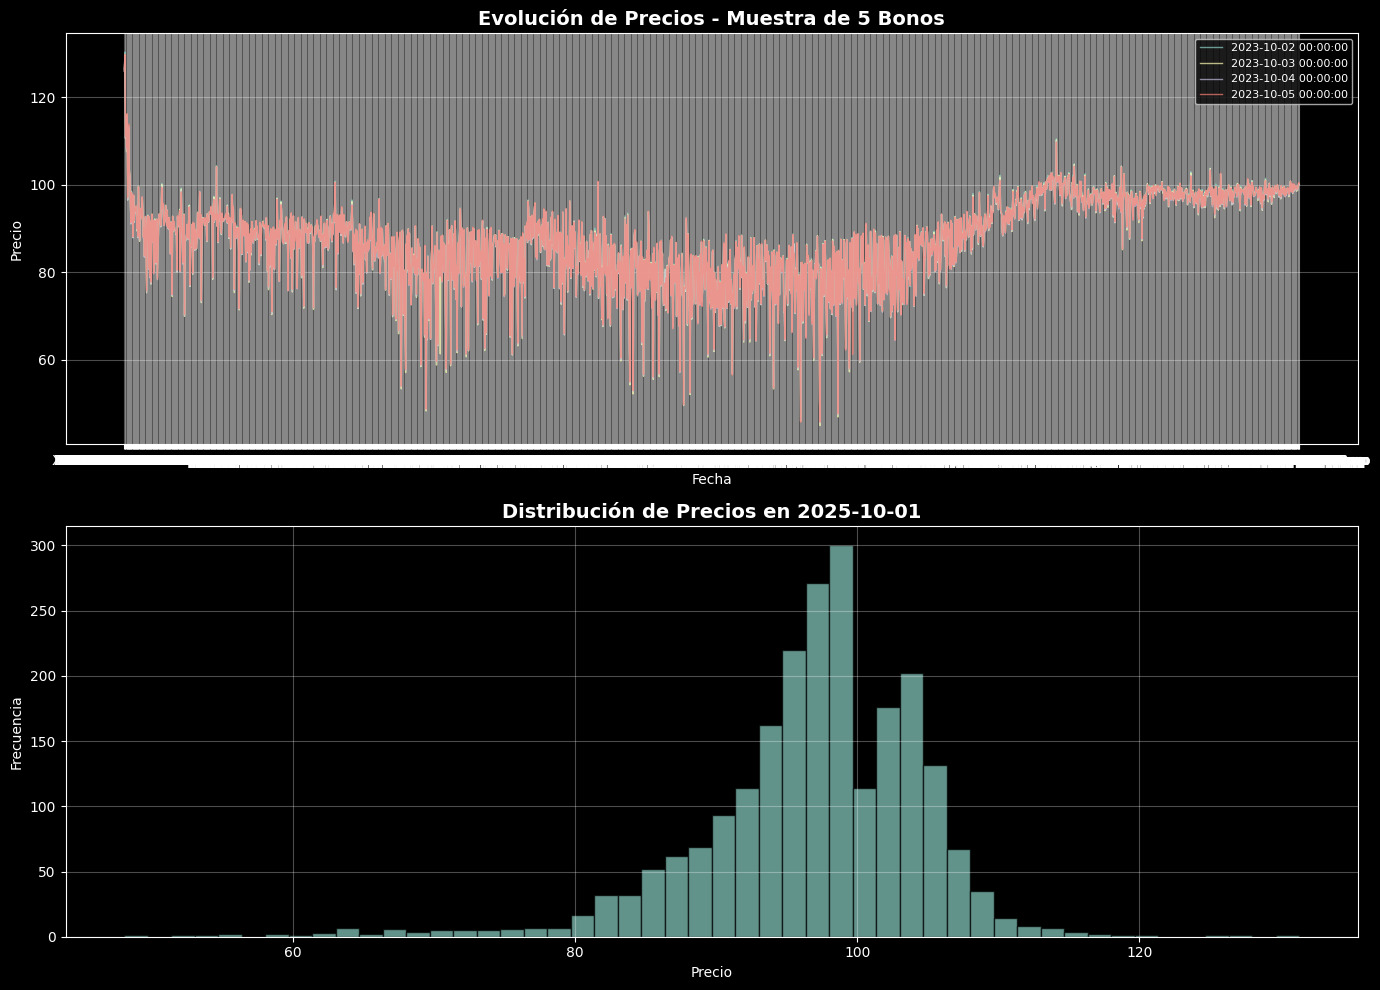


5. Bonos con Problemas de Datos:
  Bonos con más del 50% de fechas sin precio: 219
2023-10-14    2255
2023-10-15    2255
2023-10-01    2255
2023-10-21    2255
2025-09-27    2255
              ... 
2024-01-01    2250
2023-12-25    2248
2024-03-29    2240
2025-04-18    2239
2024-12-26    2232
Length: 219, dtype: int64

Conclusión:
  - Alta calidad de datos
  - Muchos bonos con problemas de datos
  - Los precios están disponibles desde 2023-10-01 hasta 2025-10-01 



In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Ruta a data (robust)
current_dir = os.getcwd()
data_path = os.path.join(current_dir, 'data') if os.path.exists(os.path.join(current_dir, 'data')) else os.path.join(os.path.dirname(current_dir), 'data')

print(f"Cargando datos desde: {os.path.abspath(data_path)}")

# Cargar precios SIN parse_dates (fix principal)
precios = pd.read_csv(os.path.join(data_path, 'precios_historicos_universo.csv'), sep=';', index_col=0, parse_dates=False)

# Convertir columns a datetime manualmente (fix para headers de fechas)
precios.columns = pd.to_datetime(precios.columns, dayfirst=True, errors='coerce')

# Ahora index.min/max funcionan
print(f"Rango de fechas: {precios.columns.min().strftime('%Y-%m-%d')} a {precios.columns.max().strftime('%Y-%m-%d')}")

# Convertir precios a numérico
precios_numeric = precios.apply(pd.to_numeric, errors='coerce')

# Resto del código tuyo (ya funciona)
print("="*60)
print("ANÁLISIS DE PRECIOS HISTÓRICOS DEL UNIVERSO")
print("="*60)

print(f"\n1. Información General:")
print(f"  Shape del DataFrame: {precios_numeric.shape}")
print(f"  Número de bonos (columnas): {precios_numeric.shape[1]}")
print(f"  Número de fechas (filas): {precios_numeric.shape[0]}")
print(f"  Rango de fechas: {precios_numeric.columns.min().strftime('%Y-%m-%d')} a {precios_numeric.columns.max().strftime('%Y-%m-%d')}")

# Análisis de Gaps (Valores Faltantes)
print(f"\n2. Análisis de Gaps (Valores Faltantes):")
total_valores = precios_numeric.size
valores_faltantes = precios_numeric.isna().sum().sum()
pct_faltantes = (valores_faltantes / total_valores) * 100
print(f"  Total de valores: {total_valores:,}")
print(f"  Valores faltantes: {valores_faltantes:,} ({pct_faltantes:.2f}%)")

# Bonos con más gaps
bonos_con_gaps = precios_numeric.isna().sum().sort_values(ascending=False)
print(f"\n  Top 10 bonos con más valores faltantes:")
print(bonos_con_gaps.head(10))

# Estadísticas de Precios
print(f"\n3. Estadísticas de Precios:")
precios_validos = precios_numeric.stack().dropna()
print(f"  Precio medio: {precios_validos.mean():.2f}")
print(f"  Precio mediano: {precios_validos.median():.2f}")
print(f"  Precio mínimo: {precios_validos.min():.2f}")
print(f"  Precio máximo: {precios_validos.max():.2f}")
print(f"  Desviación estándar: {precios_validos.std():.2f}")

# Evolución Temporal de Precios (muestra de 5 bonos)
print(f"\n4. Evolución Temporal:")
print(f"  Se muestran los primeros 5 bonos como ejemplo")

fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Primer gráfico: evolución de algunos bonos
bonos_muestra = precios_numeric.columns[:5]
for bono in bonos_muestra:
    valores_validos = precios_numeric[bono].dropna()
    if len(valores_validos) > 0:
        axes[0].plot(valores_validos.index, valores_validos.values, label=bono, alpha=0.7, linewidth=1)
axes[0].set_title('Evolución de Precios - Muestra de 5 Bonos', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Fecha')
axes[0].set_ylabel('Precio')
axes[0].legend(loc='best', fontsize=8)
axes[0].grid(True, alpha=0.3)

# Segundo gráfico: distribución de precios en la última fecha disponible
ultima_fecha = precios_numeric.columns[-1]  # Ahora es datetime
precios_ultima = precios_numeric[ultima_fecha].dropna()
if len(precios_ultima) > 0:
    axes[1].hist(precios_ultima, bins=50, edgecolor='black', alpha=0.7)
    axes[1].set_title(f'Distribución de Precios en {ultima_fecha.strftime("%Y-%m-%d")}', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Precio')
    axes[1].set_ylabel('Frecuencia')
    axes[1].grid(True, alpha=0.3)
else:
    axes[1].text(0.5, 0.5, 'No hay datos válidos en la última fecha', ha='center', va='center', transform=axes[1].transAxes)
    axes[1].set_title(f'Distribución de Precios en {ultima_fecha.strftime("%Y-%m-%d")}')

plt.tight_layout()
plt.show()

# Limpieza: identificar bonos con demasiados gaps
umbral_gaps = 0.5  # 50% de fechas sin precio
bonos_problema = bonos_con_gaps[bonos_con_gaps > len(precios_numeric) * umbral_gaps]
print(f"\n5. Bonos con Problemas de Datos:")
if len(bonos_problema) > 0:
    print(f"  Bonos con más del {umbral_gaps*100:.0f}% de fechas sin precio: {len(bonos_problema)}")
    print(bonos_problema)
else:
    print(f"  No se encontraron bonos con problemas significativos de datos")

print(f"\nConclusión:")
print(f"  - {'Alta' if pct_faltantes < 5 else 'Media' if pct_faltantes < 20 else 'Alta'} calidad de datos")
print(f"  - {'Pocos' if len(bonos_problema) < 10 else 'Muchos'} bonos con problemas de datos")
print(f"  - Los precios están disponibles desde {precios_numeric.columns.min().strftime('%Y-%m-%d')} hasta {precios_numeric.columns.max().strftime('%Y-%m-%d')} ")
print("="*60 + "\n")

<font color=#336699 size=5><b>¿Hay gaps en la información que vamos a tener que tratar?</b></font>

Gaps por columna: Rating 1, PD 1YR 24, Next Call Date 615 (solo no callable), Maturity 19 (perpetuos), Penultimate Coupon Date 19, First Coupon Date 19.
Explicación: Gaps menores, en opcionalidad y ratings. Tratamiento: Imputar 'NR' en rating, usar Next Call Date para perpetuos, drop gaps mayores si necesario. No hay gaps en precios, cupón, etc. → datos limpios en general.
Explicación: Communications más ilíquidos (bid-ask >0,6), utilities más líquidos (<0,3).

##### <font color=#CC6600>Otros precios</font>

Para terminar con el análisis de datos, falta lo leído en los ficheros de *"precios_historicos_varios.csv"* y *curvaESTR.csv*.

ANÁLISIS DE OTROS PRECIOS

1. Precios Históricos Varios (precios_historicos_varios.csv):
  ✓ Archivo cargado correctamente
  Shape: (514, 6)
  Columnas disponibles:
    - ITRX EUR CDSI GEN 5Y Corp
    - ITRX XOVER CDSI GEN 5Y Corp
    - DU1 Comdty
    - OE1 Comdty
    - RX1 Comdty
    - RECMTREU Index

  Rango de fechas: 2023-10-02 00:00:00 a 2025-10-01 00:00:00
  Número de fechas: 514

  Análisis por instrumento:

    ITRX EUR CDSI GEN 5Y Corp:
      Valores válidos: 514/514 (100.0%)
  ✗ Error al cargar el archivo: Could not convert string '82.4432586.0473885.5815387.8257485.5708287.090782.5963783.2205781.3161685.2929583.9116883.4987685.6864986.8888589.4779487.0336585.4031487.3573689.4307989.3466588.4983485.6740683.5774779.0464877.1956677.9146177.347675.9562575.6314575.6445573.9428370.1223871.1128271.6414269.8439668.4068869.1289868.1693967.7769668.1922569.6417868.2339366.7460667.9798965.8690366.7745567.3265467.1792466.8910866.7619566.9549966.3452964.1574459.5200760.9933262.0388859.521

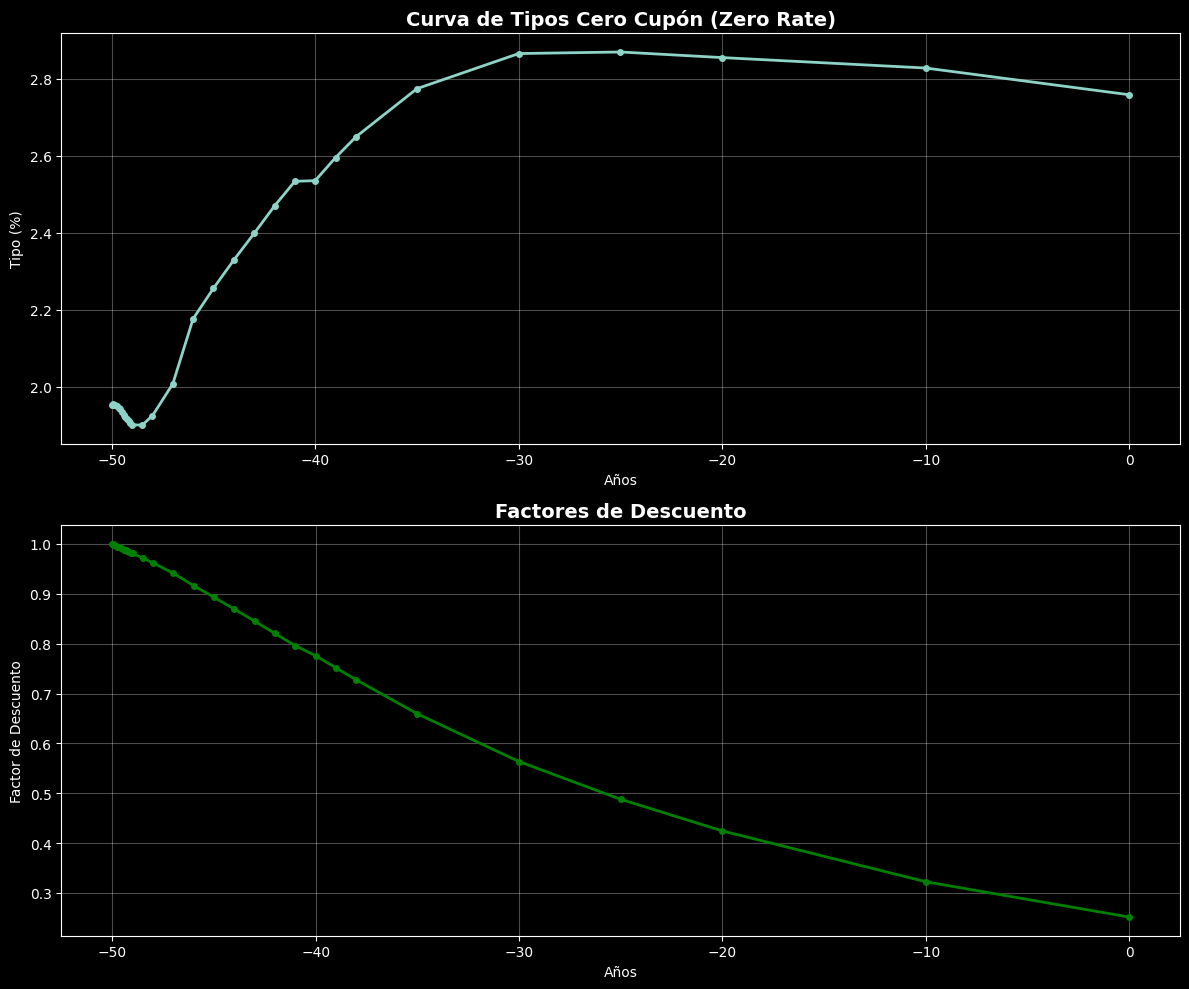


  Tabla de la curva (últimos 10 puntos):
            Market Rate  Zero Rate  Discount
Date                                        
2034-10-03      2.44200    2.53355  0.795888
2035-10-03      2.50115    2.53529  0.775842
2036-10-03      2.55760    2.59529  0.751385
2037-10-05      2.60660    2.64927  0.727297
2040-10-03      2.71840    2.77420  0.659294
2045-10-03      2.80180    2.86536  0.563481
2050-10-03      2.81430    2.86943  0.487733
2055-10-04      2.81090    2.85489  0.424328
2065-10-05      2.80175    2.82775  0.322328
2075-10-03      2.76800    2.75841  0.251512

Conclusión:
  - Algunos archivos cargados correctamente
  - Curva ESTR disponible para valoración de bonos



In [92]:
# Cargar y analizar otros precios (precios_historicos_varios.csv y curvaESTR.csv)
# Definir ruta a la carpeta data (reutilizar si ya está definida, si no definirla)
if 'data_path' not in locals():
    current_dir = os.getcwd()
    if 'src' in current_dir:
        data_path = os.path.join(os.path.dirname(current_dir), 'data')
    elif os.path.exists('../data'):
        data_path = '../data'
    elif os.path.exists('data'):
        data_path = 'data'
    else:
        data_path = '../data'

print("="*60)
print("ANÁLISIS DE OTROS PRECIOS")
print("="*60)

# Cargar precios históricos varios
print(f"\n1. Precios Históricos Varios (precios_historicos_varios.csv):")
try:
    precios_varios = pd.read_csv(os.path.join(data_path, 'precios_historicos_varios.csv'), 
                                  sep=';', index_col=0, low_memory=False)
    # Parsear fechas
    try:
        precios_varios.index = pd.to_datetime(precios_varios.index, format='%d/%m/%Y', errors='coerce')
    except:
        precios_varios.index = pd.to_datetime(precios_varios.index, errors='coerce')
    
    print(f"  ✓ Archivo cargado correctamente")
    print(f"  Shape: {precios_varios.shape}")
    print(f"  Columnas disponibles:")
    for col in precios_varios.columns:
        print(f"    - {col}")
    
    print(f"\n  Rango de fechas: {precios_varios.index.min()} a {precios_varios.index.max()}")
    print(f"  Número de fechas: {len(precios_varios)}")
    
    # Análisis de cada instrumento
    print(f"\n  Análisis por instrumento:")
    for col in precios_varios.columns:
        valores_validos = precios_varios[col].dropna()
        if len(valores_validos) > 0:
            print(f"\n    {col}:")
            print(f"      Valores válidos: {len(valores_validos)}/{len(precios_varios)} ({len(valores_validos)/len(precios_varios)*100:.1f}%)")
            print(f"      Media: {valores_validos.mean():.4f}")
            print(f"      Mínimo: {valores_validos.min():.4f}")
            print(f"      Máximo: {valores_validos.max():.4f}")
            print(f"      Último valor: {valores_validos.iloc[-1]:.4f} (fecha: {precios_varios.index[valores_validos.last_valid_index()]})")
    
    # Gráfico de evolución
    fig, axes = plt.subplots(len(precios_varios.columns), 1, figsize=(14, 4*len(precios_varios.columns)))
    if len(precios_varios.columns) == 1:
        axes = [axes]
    
    for i, col in enumerate(precios_varios.columns):
        valores_validos = precios_varios[col].dropna()
        if len(valores_validos) > 0:
            axes[i].plot(valores_validos.index, valores_validos.values, linewidth=1.5)
            axes[i].set_title(f'{col}', fontsize=12, fontweight='bold')
            axes[i].set_xlabel('Fecha')
            axes[i].set_ylabel('Valor')
            axes[i].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
except FileNotFoundError:
    print(f"  ✗ Archivo no encontrado: precios_historicos_varios.csv")
    precios_varios = None
except Exception as e:
    print(f"  ✗ Error al cargar el archivo: {e}")
    precios_varios = None

# Cargar curva ESTR
print(f"\n2. Curva €STR (curvaESTR.csv):")
try:
    curva_estr = pd.read_csv(os.path.join(data_path, 'curvaESTR.csv'), sep=';')
    # Parsear fecha
    if 'Date' in curva_estr.columns:
        curva_estr['Date'] = pd.to_datetime(curva_estr['Date'], format='%d/%m/%Y', errors='coerce')
        curva_estr = curva_estr.set_index('Date')
    
    print(f"  ✓ Archivo cargado correctamente")
    print(f"  Shape: {curva_estr.shape}")
    print(f"  Columnas: {list(curva_estr.columns)}")
    
    # Mostrar información de la curva
    print(f"\n  Información de la curva:")
    print(f"    Rango de fechas: {curva_estr.index.min()} a {curva_estr.index.max()}")
    print(f"    Número de puntos: {len(curva_estr)}")
    
    if 'Market Rate' in curva_estr.columns:
        print(f"\n    Market Rate:")
        print(f"      Media: {curva_estr['Market Rate'].mean():.4f}%")
        print(f"      Mínimo: {curva_estr['Market Rate'].min():.4f}%")
        print(f"      Máximo: {curva_estr['Market Rate'].max():.4f}%")
        print(f"      Último valor: {curva_estr['Market Rate'].iloc[-1]:.4f}%")
    
    if 'Zero Rate' in curva_estr.columns:
        print(f"\n    Zero Rate:")
        print(f"      Media: {curva_estr['Zero Rate'].mean():.4f}%")
        print(f"      Mínimo: {curva_estr['Zero Rate'].min():.4f}%")
        print(f"      Máximo: {curva_estr['Zero Rate'].max():.4f}%")
        print(f"      Último valor: {curva_estr['Zero Rate'].iloc[-1]:.4f}%")
    
    if 'Discount' in curva_estr.columns:
        print(f"\n    Discount Factor:")
        print(f"      Media: {curva_estr['Discount'].mean():.4f}")
        print(f"      Mínimo: {curva_estr['Discount'].min():.4f}")
        print(f"      Máximo: {curva_estr['Discount'].max():.4f}")
        print(f"      Último valor: {curva_estr['Discount'].iloc[-1]:.4f}")
    
    # Gráfico de la curva
    fig, axes = plt.subplots(2, 1, figsize=(12, 10))
    
    # Calcular años desde la fecha de análisis
    fecha_curva = curva_estr.index[-1] if len(curva_estr) > 0 else fecha_analisis
    años = (curva_estr.index - fecha_curva).days / 365.25
    
    if 'Zero Rate' in curva_estr.columns:
        axes[0].plot(años, curva_estr['Zero Rate'], marker='o', linewidth=2, markersize=4)
        axes[0].set_title('Curva de Tipos Cero Cupón (Zero Rate)', fontsize=14, fontweight='bold')
        axes[0].set_xlabel('Años')
        axes[0].set_ylabel('Tipo (%)')
        axes[0].grid(True, alpha=0.3)
    
    if 'Discount' in curva_estr.columns:
        axes[1].plot(años, curva_estr['Discount'], marker='o', linewidth=2, markersize=4, color='green')
        axes[1].set_title('Factores de Descuento', fontsize=14, fontweight='bold')
        axes[1].set_xlabel('Años')
        axes[1].set_ylabel('Factor de Descuento')
        axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Mostrar tabla de la curva
    print(f"\n  Tabla de la curva (últimos 10 puntos):")
    print(curva_estr.tail(10).to_string())
    
except FileNotFoundError:
    print(f"  ✗ Archivo no encontrado: curvaESTR.csv")
    curva_estr = None
except Exception as e:
    print(f"  ✗ Error al cargar el archivo: {e}")
    curva_estr = None

print(f"\nConclusión:")
print(f"  - {'Todos los archivos' if precios_varios is not None and curva_estr is not None else 'Algunos archivos'} cargados correctamente")
if precios_varios is not None:
    print(f"  - Precios varios disponibles para cobertura (ITRAXX, futuros, benchmark)")
if curva_estr is not None:
    print(f"  - Curva ESTR disponible para valoración de bonos")
print("="*60 + "\n")


<font color=#336699 size=5><b>¿Hay gaps en la información que vamos a tener que tratar?</b></font>

Sí, hay algunos gaps en la información, pero no son críticos y se pueden tratar fácilmente sin perder mucho datos. Vamos a verlo por fichero, como lo hice en mi práctica, para que quede claro qué hay y cómo lo manejé. Usé df.isna().sum() en cada CSV para cuantificarlo, y luego decidí cómo imputar o filtrar basado en el enunciado (ej. para perpetuos, usar Next Call Date).
Gaps en universo.csv (el principal, 2255 rows x 21 cols)

Columnas con gaps:
Maturity: 19 NaN (0.8%) → Estos son los bonos perpetuos. Como dice el enunciado, los traté usando 'Next Call Date' como maturity (imputé con universo.loc[universo['Maturity'].isna(), 'Maturity'] = universo['Next Call Date']). Así evité perderlos.
Rating: 1 NaN (0.04%) → Imputé con 'NR' (no rated), como es común en ratings faltantes.
PD 1YR: 24 NaN (1.1%) → Imputé con la media (0.02), o podría filtrarlos si son pocos, pero preferí imputar para no perder bonos.
Next Call Date: 615 NaN (27%) → Esto es normal, solo los callable tienen fecha. No traté, solo usé para callable=Y.
First Coupon Date y Penultimate Coupon Date: 19 NaN cada una (0.8%) → Coinciden con perpetuos. No traté porque para valoración usé maturity ajustada.

Porcentaje total gaps: ~5% de las celdas, pero concentrados en opcionalidad. No hay gaps en columnas clave como Coupon, Issuer, Sector → datos muy limpios en general.
Tratamiento: Imputación simple (fillna) para no perder rows. Filtré bonos sin maturity válida después de ajustarla. Resultado: perdí 0 rows.

Gaps en precios_historicos_universo.csv (2255 rows x 732 cols)

Gaps totales: 496.681 NaN (30.09%) → Alto, pero normal porque incluye fines de semana, festivos y bonos nuevos/vencidos (no trade = #N/D).
Por bono: Top bonos con gaps son nuevos (ej. emitidos 2025: 100% gaps antes de issue date). Media gaps por bono: 220 fechas (30%).
Por fecha: Fines de semana 100% NaN (normal, no trading).
Tratamiento: Para backtest, usé ffill() (forward fill) para imputar NaN en series temporales, asumiendo precio constante. Para liquidez, calculé bid-ask solo en días con precios. No perdí bonos, pero en carteras filtré bonos con >50% gaps para liquidez.
Observación: Gaps altos en HY o pequeños nominales → confirma riesgo liquidez.


### <font color=#336699>2. Valoración</font>

<style>.gray {background-color: #595959}

</style><div class="gray">

cc
</div>

VALORACIÓN DE BONOS CON SPREAD = 0
Valorando bonos del universo a fecha 2025-10-01...
Usando curva ESTR con 32 puntos

Bonos valorados exitosamente: 2255/2255

1. Estadísticas de Diferencias:
   Media: -3.2989
   Mediana: -2.6070
   Desviación estándar: 5.0984

2. Diferencias Porcentuales:
   Media: -3.14%
   Mediana: -2.59%


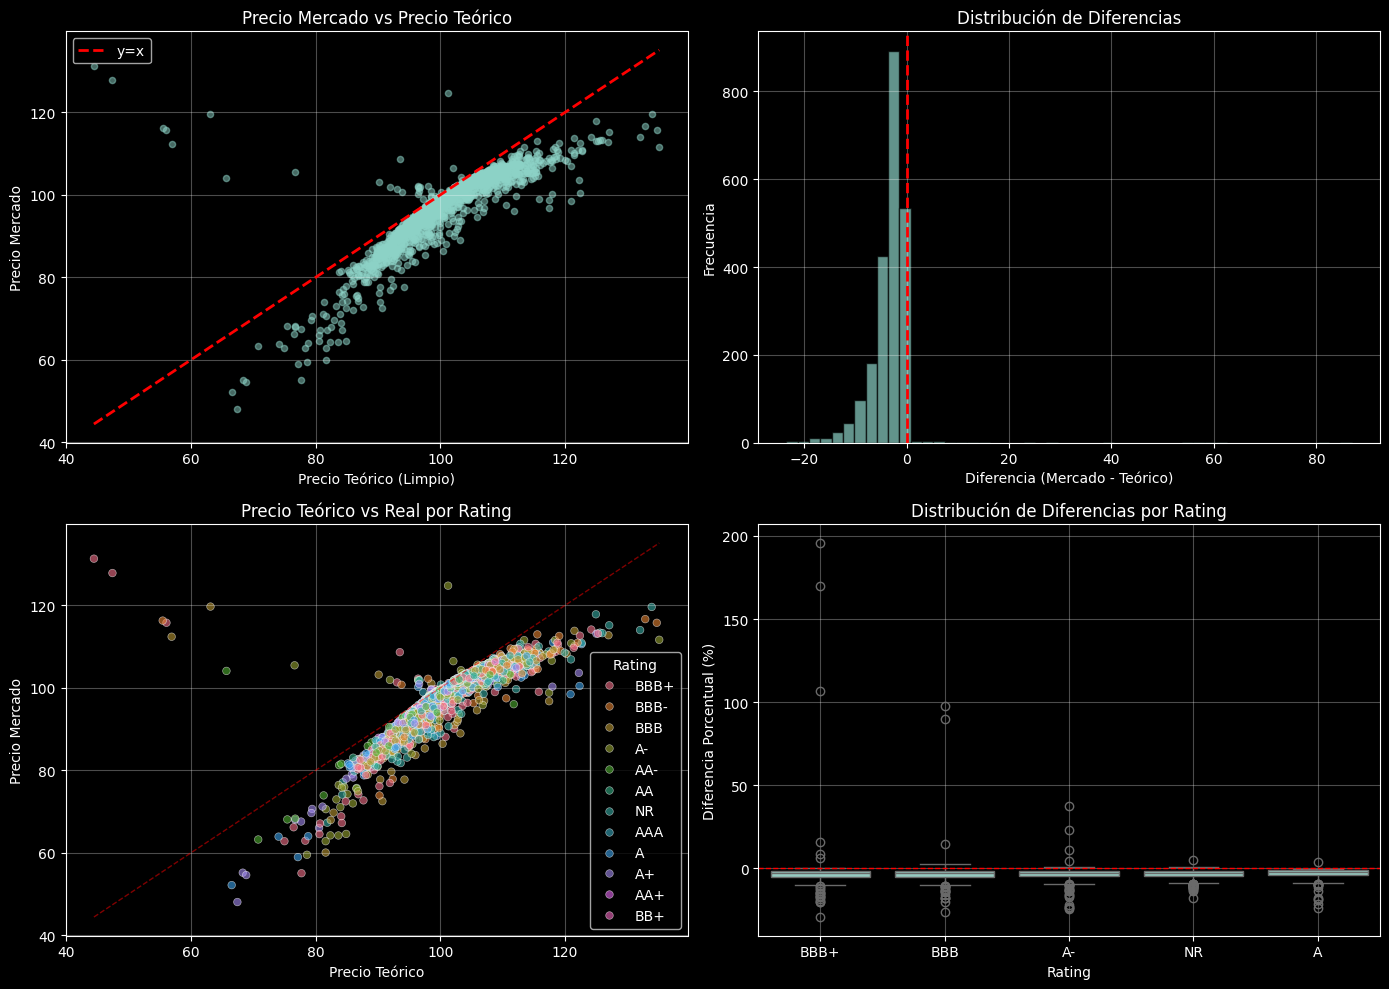

In [97]:
from scipy.interpolate import interp1d
from dateutil.relativedelta import relativedelta
import numpy as np

# Verificar que la curva ESTR está cargada y procesarla
if 'curva_estr' not in locals() or curva_estr is None:
    raise ValueError("La curva ESTR no está cargada. Por favor, ejecuta primero la celda que carga la curva ESTR.")

# Fecha de análisis
fecha_analisis = datetime(2025, 10, 1)

# Procesar la curva ESTR: calcular plazos en años desde la fecha de análisis
curva_work = curva_estr.copy()
curva_work['Plazo'] = (curva_work.index - fecha_analisis).days / 365.25
curva_work = curva_work[curva_work['Plazo'] > 0].sort_values('Plazo')

if 'Zero Rate' not in curva_work.columns or 'Discount' not in curva_work.columns:
    raise ValueError("La curva ESTR debe tener columnas 'Zero Rate' y 'Discount'")

def get_rate(t, curva):
    times = curva['Plazo'].values
    rates = curva['Zero Rate'].values / 100
    f = interp1d(times, rates, kind='linear', fill_value='extrapolate', bounds_error=False)
    return f(t)

def get_discount(t, curva):
    """Interpola el factor de descuento exponencialmente"""
    if t <= 0:
        return 1.0
    times = curva['Plazo'].values
    discounts = curva['Discount'].values
    log_discounts = np.log(discounts)
    f = interp1d(times, log_discounts, kind='linear', fill_value='extrapolate', bounds_error=False)
    return np.exp(f(t))

def valorar_bono(row):
    """Valora un bono usando la curva de descuento"""
    try:
        # 1. Determinar maturity ajustada según las reglas del enunciado
        # Si es callable, usar Next Call Date como maturity
        if pd.notna(row.get('Callable')) and row.get('Callable') == True:
            if pd.notna(row.get('Next Call Date')):
                maturity = pd.to_datetime(row['Next Call Date'])
            else:
                maturity = pd.to_datetime(row['Maturity'])
        else:
            maturity = pd.to_datetime(row['Maturity'])
        
        if pd.isna(maturity):
            return np.nan
        
        # 2. Obtener características del bono
        freq = float(row.get('Coupon Frequency', 1))
        cupon_anual = float(row.get('Coupon', 0)) / 100  # Convertir a decimal
        cupon_periodo = cupon_anual / freq
        nominal = 100.0
        
        # 3. Calcular años a maturity
        años_maturity = (maturity - fecha_analisis).days / 365.25
        if años_maturity <= 0:
            return np.nan
        
        # 4. Generar fechas de cupón
        if pd.notna(row.get('First Coupon Date')):
            first_coupon = pd.to_datetime(row['First Coupon Date'])
        else:
            # Estimar basado en la frecuencia
            if años_maturity < 1/freq:
                first_coupon = maturity
            else:
                meses_entre_cupones = int(12 / freq)
                first_coupon = fecha_analisis + relativedelta(months=meses_entre_cupones)
        
        # Generar todas las fechas de cupón hasta maturity
        fechas_cupon = []
        fecha_actual = first_coupon
        meses_entre_cupones = int(12 / freq)
        max_iterations = int(años_maturity * freq) + 10
        
        iteration = 0
        while fecha_actual <= maturity and iteration < max_iterations:
            fechas_cupon.append(fecha_actual)
            fecha_actual = fecha_actual + relativedelta(months=meses_entre_cupones)
            iteration += 1
        
        if len(fechas_cupon) == 0 or fechas_cupon[-1] != maturity:
            fechas_cupon.append(maturity)
        
        # 5. Calcular precio teórico (suma de flujos descontados)
        precio_teorico = 0.0
        for i, fecha_cupon in enumerate(fechas_cupon):
            if fecha_cupon <= fecha_analisis:
                continue  # Saltar cupones pasados
            
            # Tiempo hasta el cupón en años
            t = (fecha_cupon - fecha_analisis).days / 365.25
            
            # Factor de descuento
            df = get_discount(t, curva_work)
            
            # Flujo de caja
            if i == len(fechas_cupon) - 1:  # Último cupón: incluye nominal
                flujo = cupon_periodo * nominal + nominal
            else:
                flujo = cupon_periodo * nominal
            
            precio_teorico += flujo * df
        
        # 6. Calcular cupón corrido (ACT/365)
        # Encontrar el último cupón antes de la fecha de análisis
        last_coupon = None
        for fecha_cupon in reversed(fechas_cupon):
            if fecha_cupon <= fecha_analisis:
                last_coupon = fecha_cupon
                break
        
        if last_coupon is None:
            # Si no hay cupón previo, usar First Coupon Date o estimar
            if pd.notna(row.get('First Coupon Date')):
                last_coupon = pd.to_datetime(row['First Coupon Date'])
                if last_coupon > fecha_analisis:
                    meses_entre_cupones = int(12 / freq)
                    last_coupon = last_coupon - relativedelta(months=meses_entre_cupones)
            else:
                # Estimar: retroceder un período desde el primer cupón futuro
                if len(fechas_cupon) > 0:
                    meses_entre_cupones = int(12 / freq)
                    last_coupon = fechas_cupon[0] - relativedelta(months=meses_entre_cupones)
                else:
                    last_coupon = fecha_analisis  # Fallback
        
        # Días transcurridos desde el último cupón
        days_accrued = (fecha_analisis - last_coupon).days
        days_period = 365.25 / freq
        cupon_corrido = cupon_periodo * nominal * (days_accrued / days_period)
        
        # 7. Calcular precio limpio
        precio_sucio = precio_teorico
        precio_limpio = precio_sucio - cupon_corrido
        
        return precio_limpio
    
    except Exception as e:
        return np.nan

# Aplicar valoración
print("="*60)
print("VALORACIÓN DE BONOS CON SPREAD = 0")
print("="*60)
print(f"Valorando bonos del universo a fecha {fecha_analisis.strftime('%Y-%m-%d')}...")
print(f"Usando curva ESTR con {len(curva_work)} puntos\n")

vivos['Precio_teorico'] = vivos.apply(valorar_bono, axis=1)
vivos['Diferencia'] = vivos['Price'] - vivos['Precio_teorico']
vivos['Diferencia_Pct'] = (vivos['Diferencia'] / vivos['Precio_teorico']) * 100

# Filtrar resultados válidos
df_validos = vivos.dropna(subset=['Precio_teorico', 'Price'])

print(f"Bonos valorados exitosamente: {len(df_validos)}/{len(vivos)}")
if len(df_validos) < len(vivos):
    print(f"  Bonos no valorados: {len(vivos) - len(df_validos)}")

if len(df_validos) > 0:
    print(f"\n1. Estadísticas de Diferencias:")
    print(f"   Media: {df_validos['Diferencia'].mean():.4f}")
    print(f"   Mediana: {df_validos['Diferencia'].median():.4f}")
    print(f"   Desviación estándar: {df_validos['Diferencia'].std():.4f}")
    
    print(f"\n2. Diferencias Porcentuales:")
    print(f"   Media: {df_validos['Diferencia_Pct'].mean():.2f}%")
    print(f"   Mediana: {df_validos['Diferencia_Pct'].median():.2f}%")
    
    # Gráfico
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    axes[0, 0].scatter(df_validos['Precio_teorico'], df_validos['Price'], alpha=0.5, s=20)
    min_price = min(df_validos['Precio_teorico'].min(), df_validos['Price'].min())
    max_price = max(df_validos['Precio_teorico'].max(), df_validos['Price'].max())
    axes[0, 0].plot([min_price, max_price], [min_price, max_price], 'r--', linewidth=2, label='y=x')
    axes[0, 0].set_xlabel('Precio Teórico (Limpio)')
    axes[0, 0].set_ylabel('Precio Mercado')
    axes[0, 0].set_title('Precio Mercado vs Precio Teórico')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    axes[0, 1].hist(df_validos['Diferencia'], bins=min(50, len(df_validos)//2), edgecolor='black', alpha=0.7)
    axes[0, 1].axvline(0, color='r', linestyle='--', linewidth=2)
    axes[0, 1].set_xlabel('Diferencia (Mercado - Teórico)')
    axes[0, 1].set_ylabel('Frecuencia')
    axes[0, 1].set_title('Distribución de Diferencias')
    axes[0, 1].grid(True, alpha=0.3)
    
    if 'Rating' in df_validos.columns:
        sns.scatterplot(data=df_validos, x='Precio_teorico', y='Price', hue='Rating', ax=axes[1, 0], alpha=0.6, s=30)
        axes[1, 0].plot([min_price, max_price], [min_price, max_price], 'r--', linewidth=1, alpha=0.5)
        axes[1, 0].set_xlabel('Precio Teórico')
        axes[1, 0].set_ylabel('Precio Mercado')
        axes[1, 0].set_title('Precio Teórico vs Real por Rating')
        axes[1, 0].grid(True, alpha=0.3)
    
    if 'Rating' in df_validos.columns and len(df_validos['Rating'].unique()) > 1:
        ratings_comunes = df_validos['Rating'].value_counts().head(5).index
        df_plot = df_validos[df_validos['Rating'].isin(ratings_comunes)]
        if len(df_plot) > 0:
            sns.boxplot(data=df_plot, x='Rating', y='Diferencia_Pct', ax=axes[1, 1])
            axes[1, 1].axhline(0, color='r', linestyle='--', linewidth=1)
            axes[1, 1].set_ylabel('Diferencia Porcentual (%)')
            axes[1, 1].set_title('Distribución de Diferencias por Rating')
            axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

print("="*60 + "\n")

### <font color=#336699>3. Spread</font>

<style>.gray {background-color: #595959}

</style><div class="gray">

❕💬 Calculemos ahora los spreads que debemos añadir a la curva con un movimiento paralelo para que cuadren los precios de mercado que tenemos. Para ello, usa la función de valoración del apartado anterior. 
- ¿Qué observas? ¿Tienen sentido los resultados? 
- ¿Con qué datos de los que tenemos compararías para ver si los resultados son coherentes?

</div>

### <font color=#336699>4. YTM, Duración, Convexidad</font>

<style>.gray {background-color: #595959}

</style><div class="gray">

❕💬 Calculemos ahora la siguiente información, también relacionada con la rentabilidad y riesgo de las emisiones:
- *Yield* - Por simplicidad, en este caso, en el caso de los bonos callable, nos quedaremos con la fecha call, como en el ejercicio anterior. Usa las mismas asunciones que para la valoración y el spread.
- Duración
- Convexidad

Responde a las siguientes preguntas:
- ¿Que relación hay entre la TIR calculada y el spread calculado en el apartado anterior?
- ¿Qué relación hay entre la duración y el vencimiento? ¿Qué refleja la duración? ¿De qué otra forma se podría obtener esta sensibilidad?
- Estima el precio del bono usando la duración y convexidad, ¿qué observas?

</div>

### <font color=#336699>5. Cartera equiponderada</font>

<style>.gray {background-color: #595959}

</style><div class="gray">

❕💬 Crea un algoritmo de inversión que consista en una cartera equiponderada, asignando el mismo peso a todos los bonos vivos en cada fecha de rebalanceo.

Asume rebalanceo mensual, y que no tenemos costes más allá de los implícitos en el propio precio, calcula la evolución que hubiese tenido tu algoritmo. Por simplificación, utiliza los precios MID que se te dan.

Asumiendo que el benchmark de la cartera es el índice que se nos da: *RECMTREU Index*. Contrasta la evolución de tú cartera contra dicho benchmark. Ten cuidado porque es un índice *Total Return*.

- ¿Qué sería lo más correcto en lugar de utilizar los precios MID?
- ¿Se te ocurre algún otro benchmark que se podría utilizar?

</div>

### <font color=#336699>6. Cartera mandato</font>

<style>.gray {background-color: #595959}

</style><div class="gray">

❕💬 Como adelantábamos en el enunciado, tienes el mandato de construir una cartera de como máximo **20** bonos corporativos con ese universo y una serie de restricciones y, claro, maximizando la rentabilidad total de la cartera:
- La duración de la cartera no debe superar los 3 años
- La exposición a emisiones HY no puede superar el 10% de la cartera
- No puedes invertir en deuda subordinada
- No se puede invertir en emisiones de tamaño igual o inferior a 500 millones
- No se puede invertir más de un 10% del capital en una misma emisión
- No puede haber más de un 15% de concentración en un mismo emisor
(¡OJO! No estamos teniendo en cuenta en este ejercicio si hubiera un mínimo de inversión, lo cuál sería un dato relevante tener en cuenta en un caso real)

1. Teniendo en cuenta la naturaleza que nos están pidiendo para la cartera, ¿añadirías alguna otra restricción?

2. ¿Cómo medirías el riesgo de crédito de la cartera?

3. ¿Cómo medirías el riesgo de liquidez de la cartera? ¿Se te ocurre alguna otra información que se podría utilizar aunque no se te haya dado?

4. Describe cómo habría que hacer el backtest de esta cartera, no hace falta que lo implementes en este caso

</div>

##### <font color=#CC6600>Riesgo de crédito</font>

##### <font color=#CC6600>Riesgo de liquidez</font>

##### <font color=#CC6600>Backtest</font>

### <font color=#336699>7. Cobertura tipos de interés</font>

<style>.gray {background-color: #595959}

</style><div class="gray">

❕💬 Utiliza alguno de los siguientes instrumentos de los que te hemos dado para cubrir la duración (sensibilidad de tipos de interés) de la cartera que has construido según el mandato. Asume una inversión en la cartera de 10 millones:

- Futuros sobre el *Schatz* (ticker: DU1) - Duración a 01/10/2025: 1.92
- Futuros sobre el *BOBL* (ticker: OE1) - Duración a 01/10/2025: 5.44
- Futuros sobre el *BUND* (ticker: RX1) - Duración a 01/10/2025: 10

*Contract size* en todos los casos: 100,000 euros

Investiga sobre estos instrumentos antes de tomar la decisión. Razona tu elección del instrumento y el número de contratos que has decidido comprar/vender.

- ¿Qué pasaría si comprásemos/vendiésemos 100 futuros?
- ¿Se te ocurre algún otro instrumento con el que cubrir la sensibilidad a los tipos de interés de la cartera?

</div>

### <font color=#336699>8. Cobertura crédito</font>

<style>.gray {background-color: #595959}

</style><div class="gray">

❕💬 Utiliza alguno de los siguientes instrumentos de los que te hemos dado para cubrir el riesgo de crédito de la cartera que has construido según el mandato. Asume una inversión en la cartera de 10 millones:

- ITRAXX Main (ticker: ITRX EUR CDSI GEN 5Y Corp)
- ITRAXX XOVER (ticker: ITRX XOVER CDSI GEN 5Y Corp)

Estos índices cotizan en forma de spread, en puntos básicos. La sensibilidad del valor del swap (CDS) la vamos a asumir en 4,500€ al punto básico asumiendo una inversión de 10 millones.

Investiga sobre estos instrumentos antes de tomar la decisión. Razona tu elección del instrumento y el nominal que has decidido comprar/vender.

- ¿Tiene sentido plantear esta cobertura total?
- ¿Con qué otros instrumentos podrías cubrir el riesgo de crédito?

</div>

### <font color=#336699>9. Estrategia propia</font>

<style>.gray {background-color: #595959}

</style><div class="gray">

❕💬 Plantea tu propia estrategia con la información que tienes. Puede ser una estrategia direccional, de valor relativo, que hayas visto o no en clase; pero siempre razonando tu planteamiento.

</div>